## Libraries

In [46]:
#pip install mlxtend

In [71]:

import numpy as np
import torch
import pandas as pd
import sklearn
import random

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [72]:
import matplotlib.pyplot as plt
from mlxtend.plotting import heatmap
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

## Coefficient of determination 
from sklearn.metrics import r2_score

In [73]:
import xgboost as xgb

In [74]:
import onnxruntime as rt
import onnxmltools
from skl2onnx.common.data_types import FloatTensorType

In [75]:
#pip install onnxmltools
#!pip install skl2onnx

## Parameters

In [76]:
batch_size = 20
learning_rate = 0.001
N_Epochs = 401

epsilon = 0.0001

In [77]:
path_data = 'data/winequality-white.csv'
Wine_raw_data = pd.read_csv( path_data, delimiter=";")

In [78]:
Wine_raw_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [79]:

header_list = Wine_raw_data.columns.values.tolist()
header_list

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [80]:
headers_list2 = ['density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']


## Data Analysis
* Correlation matrix

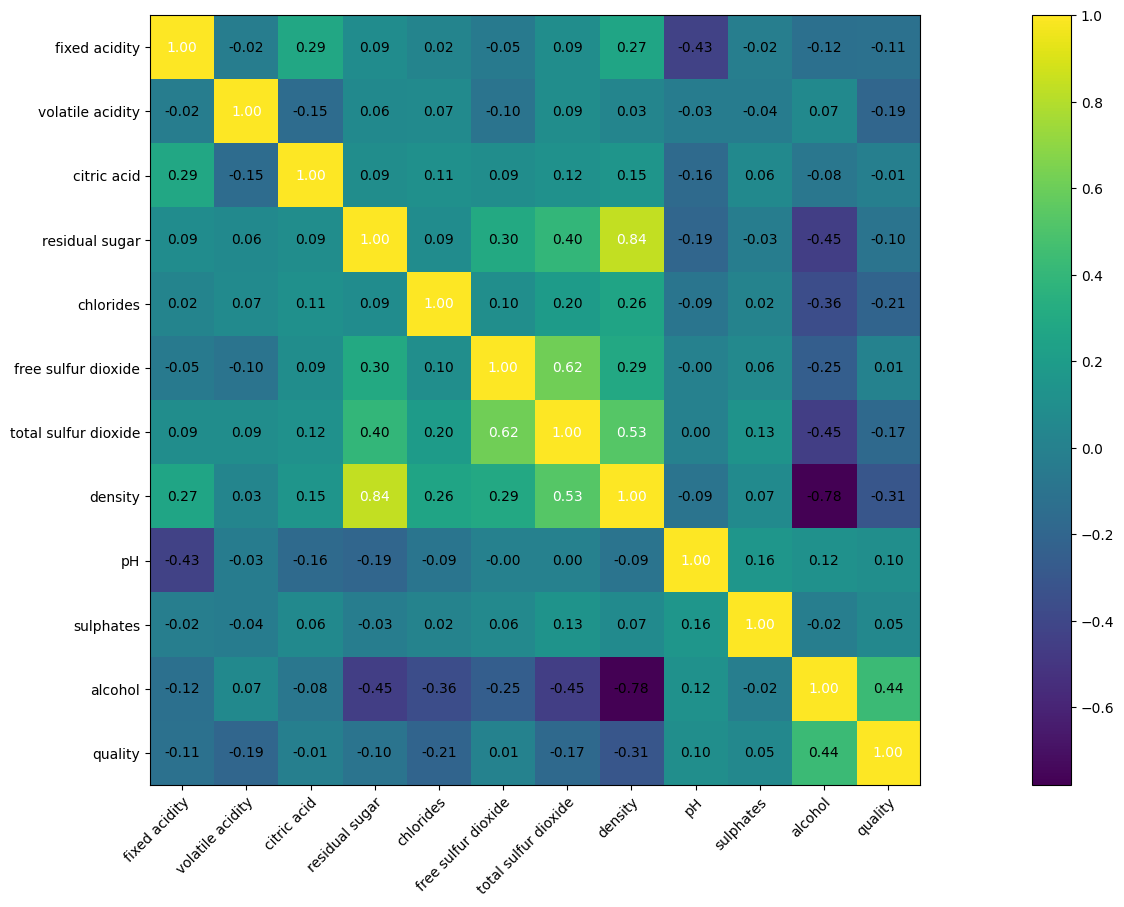

In [81]:


cm = np.corrcoef( Wine_raw_data.values.T)
hm = heatmap(cm, row_names=header_list, column_names=header_list, figsize=(29,10))
plt.show()



## Process Data

In [82]:

## Convert Pandas to Numpy

Wine_raw_data_np = Wine_raw_data.to_numpy()

In [83]:
Wine_raw_data_np.shape

(4898, 12)

In [84]:
Wine_raw_data_np

array([[ 7.  ,  0.27,  0.36, ...,  0.45,  8.8 ,  6.  ],
       [ 6.3 ,  0.3 ,  0.34, ...,  0.49,  9.5 ,  6.  ],
       [ 8.1 ,  0.28,  0.4 , ...,  0.44, 10.1 ,  6.  ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
       [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
       [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]])

In [85]:
X = Wine_raw_data_np[:, :-1]

y = Wine_raw_data_np[:, 11:12]


In [86]:
print(X.shape)
print(y.shape)

(4898, 11)
(4898, 1)


In [87]:
random_seed = int(random.random() * 100 ) ## 42

In [88]:

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=random_seed)

In [89]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3918, 11)
(980, 11)
(3918, 1)
(980, 1)


In [90]:
X_train.dtype

dtype('float64')

## Fix in case float64 error

In [91]:
## fix data type
X_train = X_train.astype( np.float32 )
X_test = X_test.astype( np.float32 )
y_train = y_train.astype( np.float32 )
y_test = y_test.astype( np.float32 )

In [92]:
X_train_tr = torch.from_numpy(X_train)
X_test_tr = torch.from_numpy(X_test)
y_train_tr = torch.from_numpy(y_train)
y_test_tr = torch.from_numpy(y_test)

## Normalization

* Normalization
* Standardization(*)

In [93]:

x_mean = X_train_tr.mean(0, keepdim= True)
x_deviation = X_train_tr.std(0, keepdim = True) + epsilon

In [94]:
x_mean

tensor([[6.8657e+00, 2.7784e-01, 3.3471e-01, 6.3374e+00, 4.5748e-02, 3.5321e+01,
         1.3800e+02, 9.9400e-01, 3.1884e+00, 4.8907e-01, 1.0532e+01]])

In [95]:
x_deviation

tensor([[8.5073e-01, 1.0099e-01, 1.2218e-01, 5.0719e+00, 2.1903e-02, 1.7100e+01,
         4.2590e+01, 3.1037e-03, 1.5274e-01, 1.1401e-01, 1.2321e+00]])

## Create the DataLoader

In [96]:
train_ds = TensorDataset( X_train_tr, y_train_tr)

In [97]:
train_dl = DataLoader( train_ds, batch_size, shuffle= True )

In [98]:
train_dl

## Neural Network Architectures

In [99]:
## Linear Regression

class LinRegNet(nn.Module):
    ## init the class
    def __init__(self, x_mean, x_deviation ):
        super().__init__() 
        
        self.x_mean = x_mean
        self.x_deviation = x_deviation
        
        self.linear1 = nn.Linear(11, 1)
        
    ## perform inference
    def forward(self, x):
        x = (x - self.x_mean) / self.x_deviation ## standardization
        y_pred = self.linear1(x)
        ## return torch.round(y_pred)
        return y_pred

In [100]:

## MLP

class mlp_net(nn.Module):
    ## init the class
    def __init__(self, x_mean, x_deviation ):
        super().__init__() 
        
        self.x_mean = x_mean
        self.x_deviation = x_deviation
        
        self.linear1 = nn.Linear(11, 8)
        self.act1 = nn.Sigmoid()
        self.linear2 = nn.Linear(8, 1)
        self.dropout =nn.Dropout(0.25)
        
    ## perform inference
    def forward(self, x):
        x = (x - self.x_mean) / self.x_deviation ## standardization
        
        x = self.linear1(x)
        x= self.act1(x)
        x= self.dropout(x)
        y_pred = self.linear2(x)
        
        ## return torch.round(y_pred)
        return y_pred

In [101]:
## Deep Learning

class DL_net(nn.Module):
    ## init the class
    def __init__(self, x_mean, x_deviation ):
        super().__init__() 
        
        self.x_mean = x_mean
        self.x_deviation = x_deviation
        
        self.linear1 = nn.Linear(11, 10)
        self.act1 = nn.Sigmoid()
        self.linear2 = nn.Linear(10,6)
        self.act2 = nn.Sigmoid()
        self.linear3 = nn.Linear(6, 1)
        self.dropout =nn.Dropout(0.25)
        
    ## perform inference
    def forward(self, x):
        x = (x - self.x_mean) / self.x_deviation ## standardization
        
        x = self.linear1(x)
        x= self.act1(x)
        x= self.linear2(x)
        x = self.act2(x)
        ##x= self.dropout(x)
        y_pred = self.linear3(x)
        
        ## return torch.round(y_pred)
        return y_pred

In [102]:
## Linear plus NonLinear
## f1 + f2

class LinearplusNonLinear_net(nn.Module):
    ## init the class
    def __init__(self, x_mean, x_deviation ):
        super().__init__() 
        
        self.x_mean = x_mean
        self.x_deviation = x_deviation
        
        ## F1
        self.f1_linear1 = nn.Linear (11,1)
         
        ## F2
        self.f2_linear1 = nn.Linear(11,14)
        self.f2_act1 = nn.Sigmoid()
        self.f2_linear2 = nn.Linear(14,1)
        
       
        
    ## perform inference
    def forward(self, x):
        x = (x - self.x_mean) / self.x_deviation ## standardization
        
        #f1 
        f1 = self.f1_linear1(x)
        
        #f2
        f2= self.f2_linear1(x)
        f2=self.f2_act1(f2)
        f2=self.f2_linear2(f2)
        
        y_pred = f1 + f2
        
      
        
        ## return torch.round(y_pred)
        return y_pred

## Training loop

In [103]:

def training_loop(N_Epochs, model, loss_fn, opt):
    
    for epoch in range(N_Epochs):
        for xb, yb in train_dl:
            
            y_pred = model(xb)
            loss   = loss_fn(y_pred, yb)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
        if epoch % 200 ==0:
            #minloss=0
            #if loss<=0:
             #   minloss = loss
            print(epoch,"loss=", loss)

In [104]:
##model = LinRegNet( x_mean, x_deviation )
model = DL_net( x_mean, x_deviation )

opt     = torch.optim.Adam( model.parameters(), lr=learning_rate)
loss_fn = F.mse_loss

training_loop( N_Epochs, model, loss_fn, opt)


0 loss= tensor(28.2793, grad_fn=<MseLossBackward0>)
200 loss= tensor(0.7715, grad_fn=<MseLossBackward0>)
400 loss= tensor(0.4431, grad_fn=<MseLossBackward0>)


In [105]:
pip update jupyter-notebook

ERROR: unknown command "update"
Note: you may need to restart the kernel to use updated packages.


## Evaluating LinearplusNonLinear_net model

In [106]:
y_pred_test = model (X_test_tr)

In [107]:
y_pred_test.shape

torch.Size([980, 1])

In [108]:
y_pred_test

tensor([[6.2757],
        [5.1272],
        [5.7514],
        [6.1386],
        [5.0742],
        [5.2521],
        [6.0004],
        [7.1944],
        [5.6202],
        [5.6957],
        [6.2617],
        [5.9419],
        [6.2628],
        [5.3058],
        [5.8103],
        [5.5180],
        [6.2466],
        [5.9359],
        [5.7292],
        [4.7906],
        [5.6346],
        [5.5034],
        [6.0567],
        [6.0327],
        [5.3727],
        [6.0835],
        [5.6209],
        [6.5511],
        [6.2185],
        [5.2479],
        [5.7059],
        [5.9265],
        [6.5108],
        [4.6840],
        [5.5601],
        [5.9504],
        [6.9959],
        [5.6560],
        [5.0131],
        [6.7139],
        [5.5564],
        [6.5083],
        [4.6163],
        [5.3415],
        [5.0093],
        [5.3601],
        [5.2346],
        [6.6133],
        [4.2395],
        [5.2799],
        [6.3325],
        [6.1284],
        [5.2432],
        [5.8376],
        [5.5825],
        [5

In [109]:
 print ( "testing R**2:", r2_score(y_test_tr.numpy(),y_pred_test.detach().numpy() ))




testing R**2: 0.33248672490360687


In [110]:

y_pred_test.shape

torch.Size([980, 1])

In [111]:
y_test_tr.shape

torch.Size([980, 1])

In [112]:
list_preds = []
list_reals = []

for i in range (len(X_test_tr)):
    print("****************")
    print("pred,real")
    np_real = y_test_tr[i].detach().numpy()
    np_pred = y_pred_test[i].detach().numpy()
    print( np_pred[0], ",", np_real[0])
    list_preds.append( np_pred[0] )
    list_reals.append(np_real[0] )

****************
pred,real
6.2757215 , 7.0
****************
pred,real
5.1272225 , 5.0
****************
pred,real
5.751396 , 7.0
****************
pred,real
6.138628 , 7.0
****************
pred,real
5.0741677 , 5.0
****************
pred,real
5.252141 , 5.0
****************
pred,real
6.0004015 , 6.0
****************
pred,real
7.194382 , 8.0
****************
pred,real
5.6201754 , 6.0
****************
pred,real
5.695692 , 6.0
****************
pred,real
6.261688 , 6.0
****************
pred,real
5.941908 , 6.0
****************
pred,real
6.262842 , 6.0
****************
pred,real
5.3057594 , 5.0
****************
pred,real
5.810299 , 6.0
****************
pred,real
5.5179825 , 6.0
****************
pred,real
6.2465997 , 7.0
****************
pred,real
5.935852 , 4.0
****************
pred,real
5.729153 , 7.0
****************
pred,real
4.7906046 , 4.0
****************
pred,real
5.634589 , 6.0
****************
pred,real
5.5033627 , 6.0
****************
pred,real
6.0567164 , 6.0
****************
pred,r

5.8163967 , 6.0
****************
pred,real
5.2003603 , 5.0
****************
pred,real
6.532488 , 7.0
****************
pred,real
5.2616167 , 5.0
****************
pred,real
5.8568788 , 6.0
****************
pred,real
5.1865263 , 5.0
****************
pred,real
5.38058 , 5.0
****************
pred,real
6.0982313 , 6.0
****************
pred,real
6.8108606 , 7.0
****************
pred,real
6.2840934 , 6.0
****************
pred,real
6.214938 , 5.0
****************
pred,real
5.6589985 , 6.0
****************
pred,real
5.3064413 , 5.0
****************
pred,real
4.4701347 , 6.0
****************
pred,real
6.9915085 , 7.0
****************
pred,real
5.8418207 , 6.0
****************
pred,real
5.120578 , 6.0
****************
pred,real
6.0815306 , 5.0
****************
pred,real
5.339278 , 5.0
****************
pred,real
5.1823606 , 5.0
****************
pred,real
5.4797764 , 5.0
****************
pred,real
5.896524 , 6.0
****************
pred,real
5.363538 , 6.0
****************
pred,real
6.4713264 , 5.0
***

## Visualize test predictions

In [113]:

def plot_preds_vs_reals(list_preds,list_reals):
    
    plt.figure(figsize = (13,4))
    plt.plot(list_reals, label = 'real', color = 'r')
    plt.plot(list_preds, label = 'pred')
    plt.show

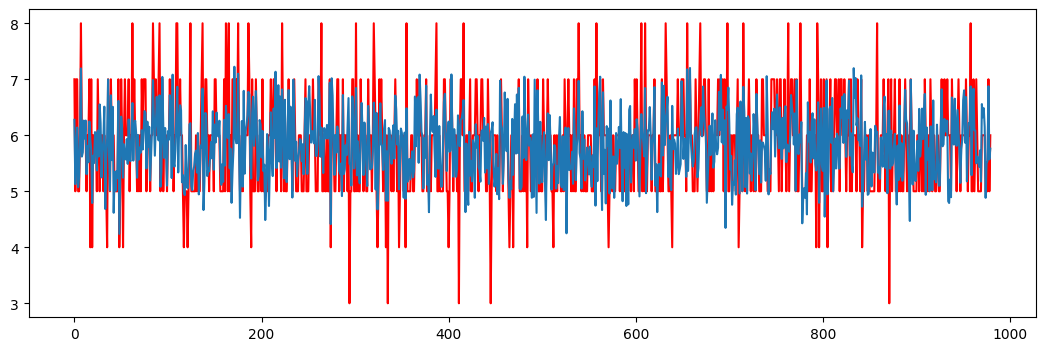

In [114]:
plot_preds_vs_reals(list_preds,list_reals)

## Deploy PyTorch Model

In [115]:
model.eval()

dummy_input = torch.randn( 1, 11)

input_names = ["input1"]
output_names = ["output1"]

torch.onnx.export(
    model, 
    dummy_input,
    "DLnet_WineData.onnx",
    verbose = False,
    input_names = input_names,
    output_names = output_names
)

## XGBoost Model



In [116]:
#pip install XGBoost

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [118]:
regressor = xgb.XGBRegressor(

    n_estimator =1000,
    reg_lambda=1,
    gamma=0,
    max_dept=9
)

In [119]:
regressor.fit(X_train, y_train)

[18:08:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "max_dept", "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_dept=9, max_depth=6, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimator=1000, n_estimators=100, n_jobs=0, num_parallel_tree=1,
             predictor='auto', random_state=0, ...)

In [120]:
y_pred = regressor.predict(X_test)

In [121]:
y_pred

array([6.020674 , 5.0450163, 6.4049525, ..., 6.5456586, 4.931229 ,
       6.9433074], dtype=float32)

In [122]:
y_test

array([[5.],
       [5.],
       [6.],
       ...,
       [7.],
       [5.],
       [6.]])

In [123]:
r2_score(y_test, y_pred)

0.48250313377112575

## Deploy Model
     * ONNX and GitHub

In [154]:
initial_types = [(
'float_input',
FloatTensorType( [None, 11])
)]

In [155]:
onnx_model = onnxmltools.convert_xgboost(regressor, initial_types = initial_types)

onnxmltools.utils.save_model(onnx_model, 'xgboost_WineQuality_ort.onnx')

In [156]:
sess = rt.InferenceSession('xgboost_WineQuality_ort.onnx')

In [157]:
input_name = sess.get_inputs()[0].name

In [158]:
input_name

'float_input'

In [159]:
label_name = sess.get_outputs()[0].name

In [160]:
label_name

'variable'

In [161]:
pred_ort = sess.run( [label_name], {input_name: X_test.astype(np.float32)})

In [162]:
pred_ort


[array([[6.0206747],
        [5.0450172],
        [6.4049525],
        ...,
        [6.545657 ],
        [4.9312277],
        [6.943307 ]], dtype=float32)]